<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/train_compare_full_data/IAMGOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
  <img alt="FINKI **LOGO**" height="30px" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  Интелигентни системи - Лабораториска вежба 2 (Претпроцесирање)
</h1>
<center><h3><i>Група 5<i><h3></center>

---



In [1]:
#@title Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#@title Инсталирање и вчитување на потребните библиотеки

# Библиотека за истражување, визуелизација и анализирање на човечки 
# неврофизиолошки податоци (EEG, sEEG и др)
!pip install mne 
!pip install termcolor

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from termcolor import colored
import mne
from sklearn.decomposition import PCA, FastICA
import mne

In [6]:
%tensorflow_version 1.12.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.12.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [7]:
!wget "https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py"
!mkdir saved_models

--2020-05-10 00:12:45--  https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18283 (18K) [text/plain]
Saving to: ‘EEGModels.py’

EEGModels.py        100%[===================>]  17.85K  --.-KB/s    in 0.001s  

2020-05-10 00:12:45 (27.9 MB/s) - ‘EEGModels.py’ saved [18283/18283]



In [17]:
#@title Fourier analysis
# Вчитување на податоците

from sklearn import metrics 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
from EEGModels import EEGNet,ShallowConvNet
import scipy.io as sio
from scipy.fft import fft
from scipy import signal
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras import backend as K
from tensorflow import keras
K.set_image_data_format('channels_first')

print(open("/root/.keras/keras.json").read())

# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 
for i in range(1, 16):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    if i == 1: continue

    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainData.mat"
    temp = loadmat(full_path)['trainData'] 
    data = np.concatenate((data, temp), axis=2)

print(data.size)
print(data.shape)

# Вчитување на label-ите
labels_arr = np.empty(0)

for i in range(1, 16):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    if i == 1: continue

    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainLabels.txt"
    with open(full_path, "r") as file_labels:
      temp = file_labels.read().splitlines()
      labels_arr = np.concatenate((labels_arr, temp))

# Вчитување на редоследот на светкање
events_arr = np.empty(0)

for i in range(1, 16):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    if i == 1: continue

    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainEvents.txt"
    with open(full_path, "r") as file_events:
      temp = file_events.read().splitlines()
      events_arr = np.concatenate((events_arr, temp))

# Вчитување на редоследот на објекти кои се target
targets_arr = np.empty(0)

for i in range(1, 16):
  file_name = 'SBJ' + format(i, '02')
  for j in range(1, 4):
    if i == 1: continue

    file_train_set = 'S' + format(j, '02') + '-Train'
    full_path = 'drive/My Drive/Интелигентни Системи/Data/' + file_name + "/" + file_train_set + "/trainEvents.txt"
    with open(full_path, "r") as file_targets:
      temp = file_targets.read().splitlines()
      targets_arr = np.concatenate((targets_arr, temp))


indecis = np.where( targets_arr == '1' )
data = np.swapaxes(data, 0, 2)
data = np.swapaxes(data, 1, 2)
data = data[indecis]
#data = data[indecis]
print(data.shape)
mne_array = data.reshape([data.shape[0],1,8, 350])
print(mne_array.shape)

#stft = mne.time_frequency.stft(mne_array[0], 24)

# Number of sample points

FS = 250
N = 350
# sample spacing
T = 1.0 / FS
x = np.linspace(0.0, N*T, N)
num_labels= 8
#plt.plot(mne_array[2][2], np.linspace(0.0,N,N))

#fig, axs = plt.subplots(8,8, figsize=(4*8,4*8))
#freq_data = list()
#for i in range(8):
#  for x in range(8):
#    f, t, Sxx = signal.spectrogram(mne_array[x][i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
#    freq_data.append(Sxx)
#    axs[i,x].pcolormesh(t, f, Sxx)
#plt.show()
#print(open("~/keras/keras.json").read())

#events_arr = list(map(int, events_arr))



#standardized_data_eeg=standardized_data_eeg.reshape([data.shape[0],1,8, 350])
events_arr = events_arr[indecis]

with open("events_arr_raw.txt", 'w') as f:
    f.write(np.array2string(events_arr, separator=', '))

events_arr = events_arr.astype(np.int)
with open("events_arr.txt", 'w') as f:
    f.write(np.array2string(events_arr, separator=', '))
X_train, X_test, y_train, y_test = train_test_split(mne_array, events_arr-1, test_size=0.33, random_state=42)


#y_train = np.array(y_train)
y_train = to_categorical(y_train)
#y_test = np.array(y_test)
y_test = to_categorical(y_test)
# Construct model 


num_epochs = 50
num_batch_size = 100

model = EEGNet(nb_classes = 8, Chans = 8, Samples = 350)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer =keras.optimizers.Adam(learning_rate=1e-2))
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)

start = datetime.now()
print("y_train:{}".format(y_train))
print("y_test:{}".format(y_test))

np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # turn off summarization, line-wrapping
with open("y_train.txt", 'w') as f:
    f.write(np.array2string(y_train, separator=', '))

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, \
          validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

score = model.evaluate(X_test, y_test, verbose=1)
#preds = model.predict(X_test, verbose=0)
#acc = accuracy_score(y_test, preds)

print("accuracy_score: {f}".format(f=score))


Streaming output truncated to the last 5000 lines.
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

ValueError: ignored

In [3]:
!readlink -f ~/.keras/keras.json

/root/.keras/keras.json


(8, 350, 100)
(8, 350, 200)


NameError: ignored

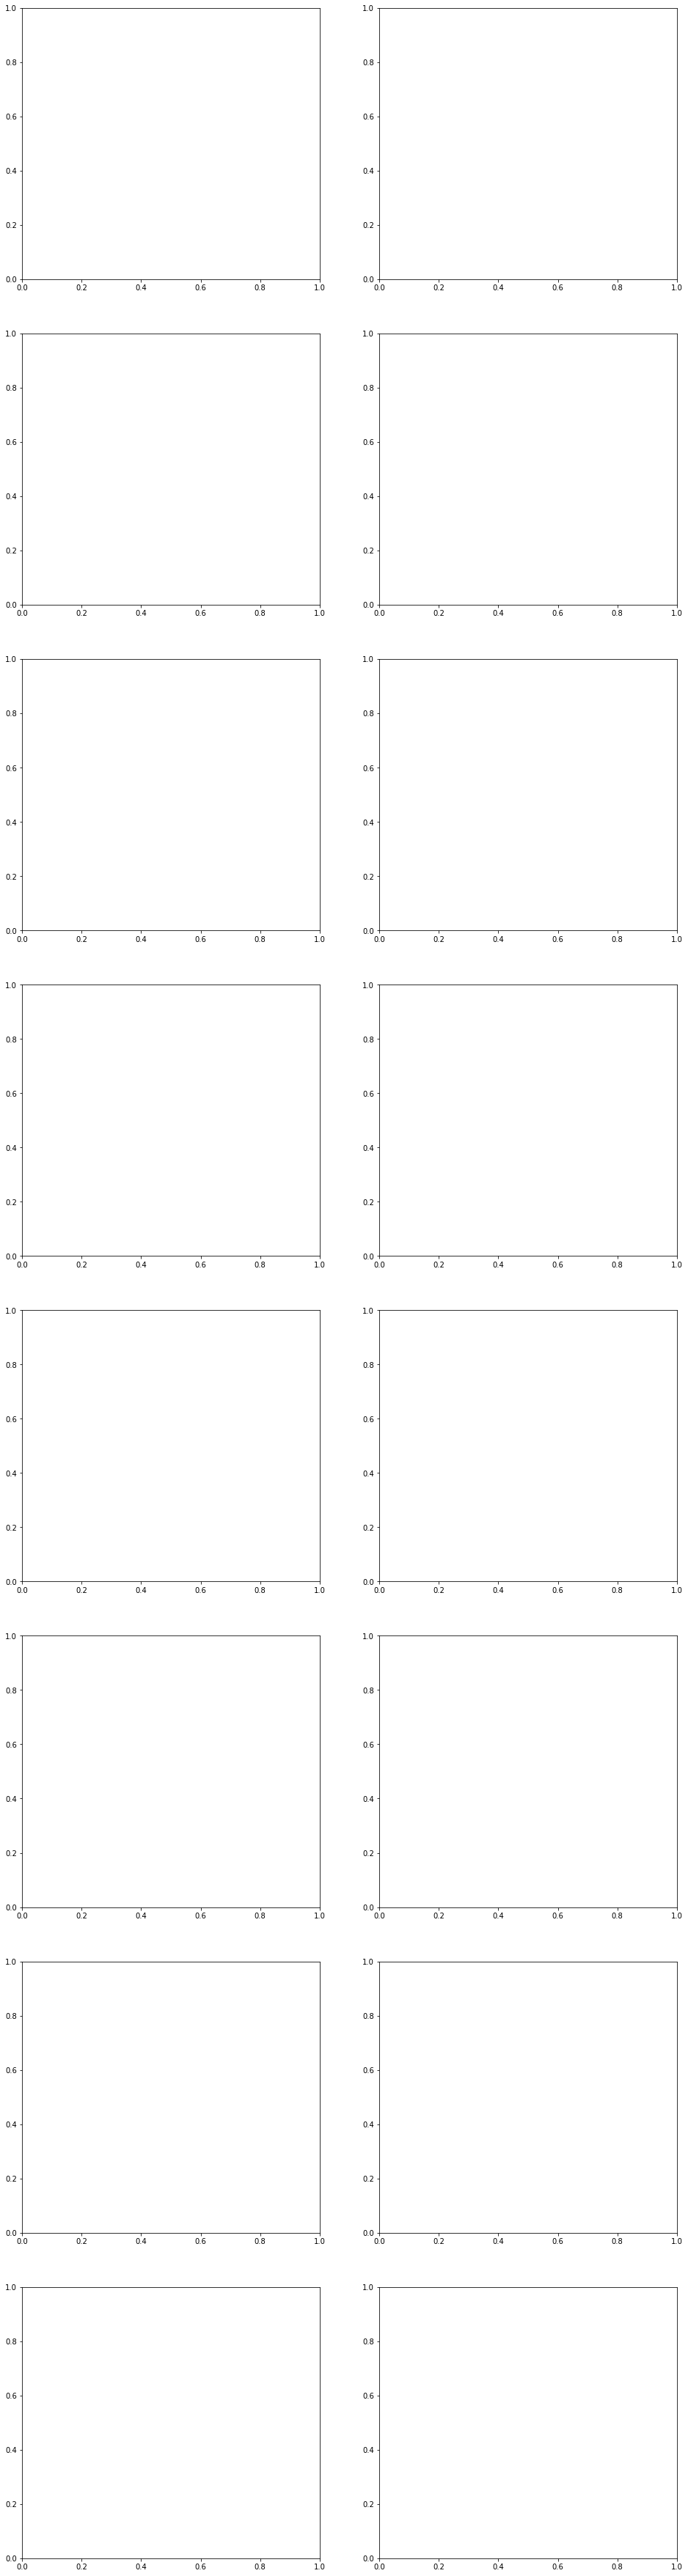

In [4]:
#@title 1st objest, target vs non target
# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 

# Вчитување на label-ите
labels_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainLabels.txt", "r") as file_labels:
    labels_arr = file_labels.read().splitlines()

# Вчитување на редоследот на светкање
events_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainEvents.txt", "r") as file_events:
    events_arr = file_events.read().splitlines()

# Вчитување на редоследот на објекти кои се target
targets_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainTargets.txt", "r") as file_targets:
    targets_arr = file_targets.read().splitlines()

# Прилагодување на податоците за користење со mne библиотеката
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
mne_info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
#mne_array = np.swapaxes(data, 0, 2) # (епохa, канал, настан). 
#mne_array = np.swapaxes(mne_array, 1, 2) # (епохa, канал, настан). 
#raw_data = mne.epochs.EpochsArray(mne_array, mne_info)

# Извлекување на настаните каде светнал првиот објект и бил target.
first_object_events_target = [index for index, value in enumerate(events_arr) if value == '1']
first_object_non_target = [index for index, value in enumerate(events_arr) if value == '1']

for event_pos in first_object_events_target:
  if targets_arr[event_pos] == 1:
    first_object_non_target.remove(event_pos)
    continue # Продолжи
  else:
    first_object_events_target.remove(event_pos) # Избриши -> Објектот не е target
first_object_target_eeg_data = np.zeros((8,350, len(first_object_events_target)))
first_object_non_target_eeg_data = np.zeros((8,350, len(first_object_non_target)))
for channel in range(0, 8): # Секој канал
  for epoch in range(0, 350): # Секоја епоха
    i = 0
    for event in first_object_events_target: # Настан
      first_object_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      i = i+1
    
    k=0
    for event in first_object_non_target: # Настан
      first_object_non_target_eeg_data[channel][epoch][i] = data[channel][epoch][event]
      k = k+1

print(first_object_target_eeg_data.shape)
print(first_object_non_target_eeg_data.shape)

first_object_target_eeg_data = np.mean(first_object_target_eeg_data, axis=2)
first_object_non_target_eeg_data = np.mean(first_object_non_target_eeg_data, axis=2)

fig, axs = plt.subplots(8,2,figsize=(16,16*4))
for i in range(8):
  f, t, Sxx = signal.spectrogram(first_object_target_eeg_data[i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
  fnon, tnon, Sxxnon = signal.spectrogram(first_object_non_target_eeg_data[i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)

  axs[i,0].pcolormesh(t, f, Sxx)
  axs[i,1].pcolormesh(tnon, fnon, Sxxnon)
plt.show()

In [0]:
Min, Max = round(mne_array_clean.min()),round(mne_array_clean.max())*1000000
picks = mne.pick_types(raw_data_clean.info, meg=False, eeg=True, stim=False, eog=False)
xd = mne.preprocessing.Xdawn(n_components=2, signal_cov=None)
xd.fit(raw_data_clean)
epochs_denoised = xd.apply(raw_data_clean)
epochs_denoised.keys()
mne.viz.plot_epochs_image(epochs_denoised['1'], picks='eeg', vmin=Min, vmax=Max)

In [0]:
type(np.swapaxes(epochs_denoised['1'],0,0))
standardizer = mne.decoding.Scaler(scalings='mean')
standardizer.fit(np.swapaxes(epochs_denoised['1'],0,0))
standardized_data = standardizer.transform(np.swapaxes(epochs_denoised['1'],0,0))


In [0]:
standardized_data.shape

In [0]:
FS = 250
N = 350
# sample spacing
T = 1.0 / FS
x = np.linspace(0.0, N*T, N)
num_labels= 8
#plt.plot(mne_array[2][2], np.linspace(0.0,N,N))

#fig, axs = plt.subplots(8,8, figsize=(4*8,4*8))
#freq_data = list()
#for i in range(8):
#  for x in range(8):
#    f, t, Sxx = signal.spectrogram(mne_array[x][i], fs=FS, nperseg=50, window=('hamming'), noverlap=35)
#    freq_data.append(Sxx)
#    axs[i,x].pcolormesh(t, f, Sxx)
#plt.show()
#print(open("~/keras/keras.json").read())

#events_arr = list(map(int, events_arr))
standardized_data_eeg = np.swapaxes(standardized_data,0,2)
standardized_data_eeg=standardized_data_eeg.reshape([1600,1,8, 350])
X_train, X_test, y_train, y_test = train_test_split(standardized_data_eeg, events_arr, test_size=0.33, random_state=42)
#y_train = np.array(y_train)
y_train = to_categorical(y_train)
#y_test = np.array(y_test)
y_test = to_categorical(y_test)
# Construct model 


num_epochs = 50
num_batch_size = 10

model = EEGNet(nb_classes = 9, Chans = 8, Samples = 350)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer = 'adam')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, \
          validation_data=(X_test, y_test),callbacks=[checkpointer], verbose=1)

score = model.evaluate(X_test, y_test, verbose=1)
#preds = model.predict(X_test, verbose=0)
#acc = accuracy_score(y_test, preds)

print("accuracy_score: {f}".format(f=score))
